# EfficientNet with Squeeze Excitation and Swin

In this model, our team builds of the efficientNet infrastructure, where we have introduced a Swin Transformer hea in addition to our two channel wise attention mechanisms.

Channel wise attention mechanisms
- Squeeze-and-Excitation (SE) Block
- Channel Attention Block (CA) Block

Context-aware global classifier
- Swin Transformer


In this notebook, our team evaluates the performance of this modified EfficientNet model

**This notebook contains the following sections:**
1. Loading Preprocessed Dataset
2. Modified EfficientNet‑B5 model architecture   
3. Hyperparameter Tuning  
4. Model Training
5. Model Evaluation

**Assumed project structure:**
```markdown
ROOT
├── notebooks
│   └── EfficientNetB5.ipynb
└── input
    └── final_split_15Apr2025
        ├── train
        ├── eval
        └── test
```
* if dataset not downloaded, dataset would download in the loading dataset section.

Configurable Variables:
- **root (str)**: Root directory of the project (commonly set to '..').
- **data_set_directory (str)**: Name of the directory containing all datasets (i.e.,'input')
- **final_data_set (str)**: Folder name of the final processed and augmented dataset used for training.
- **root_result_folder (str)**: Top-level directory name for storing evaluation results.
- **model_directory (str)**: Directory name where all trained models will be saved.
- **google_drive_id (str)**: ID used for Google Drive downloads (if applicable).
- **model_name (str)**: Abbreviation or identifier for the model being trained (used for file naming).
- **batch_size (int)**: Number of samples per training/validation batch.

In [2]:
# Control Panel to adjust variables
root = ".."
data_set_directory = "input"
final_data_set = "final_split_15Apr2025"
root_result_folder = "results"
model_directory = "models" 
google_drive_id = "1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg"

model_name = "ENSESwin" # Name of the model that the file is training in abbreviation
batch_size = 64 # State the number of datapoints in each batch size

## Imports
Used to handle the imports

In [3]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
from timm.models.swin_transformer import SwinTransformer


import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# Determine the project root - required to import DataHandler from utils folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), root))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

c:\Users\yongl\anaconda3\envs\ADLTEAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-22 21:44:34,218	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-22 21:44:34,351	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Loading Dataset and File Location Variables
All code that handles renaming of file location save files

Global Variables Created:
- **PROJECT_ROOT (str)**: Absolute path to the project’s root directory; added to `sys.path` for imports.
- **LOG_DIR (str)**: Path to the directory where log files will be written.
- **MODEL_SAVE_DIR (str)**: Directory for saving model checkpoints and final trained model files.
- **CHECKPOINT_DIR (str)**: Directory where intermediate checkpoints for hyperparameter tuning are stored.
- **RESULTS_DIR (str)**: Path to store evaluation results and metrics, separated by model name.
- **BEST_MODEL_PATH (str)**: Full path to the file where the best-performing model will be saved.
- **DATASET_FOLDER (str)**: Full path to the folder containing the dataset used for training.
- **DEVICE (torch.device)**: The hardware device selected for training ('cuda', 'mps', or 'cpu').


In [4]:
# Configuring log file
LOG_DIR = os.path.join(PROJECT_ROOT, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
log_filename = os.path.join(LOG_DIR, F"{model_name}_training_log.txt")
logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)
ROOT_DATA_DIR = os.path.join(root, data_set_directory)

# Creating the models save location
MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, model_directory, model_name)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
print(MODEL_SAVE_DIR)

CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, F"{model_directory}/hyptune/{model_name}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

RESULTS_DIR = os.path.join(PROJECT_ROOT, F"{root_result_folder}/{model_name}")
os.makedirs(RESULTS_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, F"{model_name}_best_model.pt")

DATASET_FOLDER = os.path.join(root, data_set_directory,final_data_set)
# Gets the device to be used
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

DEVICE = get_device()

c:\Users\yongl\OneDrive\Documents\GitHub\DogEmotionADL\models\ENSESwin
Using device: CUDA (GPU)


In [5]:
# Function to download the processed dataset used by the team
download_dataset(final_data_set,f"https://drive.google.com/uc?id={google_drive_id}",  F"{DATASET_FOLDER}.zip", ROOT_DATA_DIR)

Dataset already exists at final_split_15Apr2025


### Loading Dataset

In [6]:
SPLIT_DATASET = os.path.abspath(DATASET_FOLDER)
BATCH_SIZE = batch_size

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

print("LOADING SUBSET DATASET-------------------------------------------------------")
# Creating dataloader to load 50% of the dataset with the same proportions used for hyper parameter tuning
TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

print("LOADING FULL DATASET-------------------------------------------------------")
# Creating dataloader to load the full dataset for training the actual models and testing
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

LOADING SUBSET DATASET-------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69
LOADING FULL DATASET-------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572


## Model Specification
This part of the file will change largely based on each of the models that are being created


In [ ]:
class SqueezeExcitationBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) block for channel-wise feature recalibration.

    This block implements the SE mechanism which adaptively recalibrates 
    channel-wise feature responses by explicitly modeling interdependencies 
    between channels.

    Args:
        channels (int): Number of input and output channels.
        reduction_ratio (int): Reduction ratio for the intermediate hidden layer. 
            Controls the bottleneck in the SE block (default: 16).

    Forward Input:
        x (Tensor): Input feature map of shape (batch_size, channels, height, width).

    Forward Output:
        Tensor: Output feature map of the same shape, with recalibrated channel responses.
    """

    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ChannelAttentionBlock(nn.Module):
    """
    Channel Attention Block (Lightweight SE-style Attention)

    This module applies channel-wise attention to recalibrate the importance of each feature channel.
    Unlike traditional Squeeze-and-Excitation (SE) blocks that use fully connected (linear) layers,
    this implementation uses 1×1 convolutions for better compatibility with convolutional architectures.

    It compresses spatial dimensions using global average pooling, passes the result through a 
    bottleneck with ReLU activation, and applies a sigmoid gating mechanism to rescale each channel.

    Args:
        in_channels (int): Number of input and output channels in the input feature map.

    Forward Input:
        x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width)

    Forward Output:
        torch.Tensor: Output tensor of the same shape, with recalibrated channel-wise responses.
    """
    def __init__(self, in_channels: int):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg(x))
        return x * w
    

class SwinFicientNet(nn.Module):
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 unfreeze_blocks: Optional[List[int]] = None):
        super().__init__()
        """
        Initializes an instance of the model with the specified configuration.

        Args:
            num_classes (int, optional): The number of output classes for the model. Default is 4.
            dropout (float, optional): The dropout rate to be applied to the model. Default is 0.2.
            hidden_sizes (List[int], optional): A list specifying the sizes of hidden layers in the model.
                                                If None, the model will use a default configuration. Default is None.
            activation (str, optional): The activation function to use in the model. Default is 'relu'.
                                        Other possible values might include 'sigmoid', 'tanh', etc.
            unfreeze_blocks (List[int], optional): A list of blocks to be unfrozen during training.
                                                    Default is None, which means no blocks are unfrozen.

        """
        # 1) EfficientNet-B5 feature extractor only
        eff = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
        self.backbone = eff.features  # <-- 4D conv maps
        feat_channels = 2048          # EfficientNetB5's final feature‐map channels

        # Freeze all EfficientNet layers, then optionally unfreeze some
        for p in self.backbone.parameters():
            p.requires_grad = False
        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for p in self.backbone[idx].parameters():
                    p.requires_grad = True

        # 2) Squeeze‐Excitation on the conv maps
        self.se = SqueezeExcitationBlock(feat_channels)
        self.asf   = ChannelAttentionBlock(2048)

        # 3) Project into 96 channels for Swin
        self.project    = nn.Conv2d(feat_channels, 96, kernel_size=1)
        self.adapt_pool = nn.AdaptiveAvgPool2d((14, 14))

        # 4) Swin Transformer head (classifier baked in)
        self.swin = SwinTransformer(
            img_size=14,
            patch_size=1,
            in_chans=96,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=7,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.1,
            ape=False,
            patch_norm=True,
            num_classes=num_classes
        )


    def _get_activation(self, act: str) -> nn.Module:
        """
        Returns the specified activation function from PyTorch's nn module.

        Args:
            activation (str): Name of the activation function. Supported values are
                'relu', 'tanh', and 'sigmoid' (case-insensitive).

        Returns:
            Callable: The corresponding activation function module (e.g., nn.ReLU()).

        Raises:
            ValueError: If an unsupported activation function name is provided.
        """
        act = act.lower()
        return {
            'relu'     : nn.ReLU(),
            'tanh'     : nn.Tanh(),
            'sigmoid'  : nn.Sigmoid(),
            'leakyrelu': nn.LeakyReLU()
        }[act]

    def forward(self, x):
        x = self.backbone(x)    # [B, 2048, H, W]
        x = self.se(x)          # SE block
        x = self.asf(x)         # Channel Attention Block
        x = self.project(x)     # [B,  96, H, W]
        x = self.adapt_pool(x)  # [B,  96, 14,14]
        x = self.swin(x)        # [B, num_classes]
        return x


In [8]:
print(f"Using device: {DEVICE}")
model = SwinFicientNet(num_classes=4, dropout=0.3, hidden_sizes=[256, 128], activation='relu', unfreeze_blocks=[7]).to(DEVICE)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: SwinFicientNet
SwinFicientNet(
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activat

## Hyper Parameter Tuning

This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
When there are multiple hyperparameters, this is would be more efficient than grid search and random search.

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.

In [9]:
def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = SwinFicientNet(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu"),
        unfreeze_blocks = config.get("unfreeze_blocks", [7])
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()  #UPDATE: add this line for accuracy
            running_total   += targets.size(0)  #UPDATE: add this line for accuracy
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        epoch_acc  = running_correct / running_total
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        print(f"[TRAIN] epoch {epoch+1}: loss={epoch_loss:.4f} acc={epoch_acc:.3f}")  #UPDATE: edit this line for accuracy

        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0) #UPDATE: edit this variable name
            val_correct += (outputs.argmax(1) == targets).sum().item() #UPDATE: add this line for accuracy
            val_total   += targets.size(0) #UPDATE: add this line for accuracy
    
    avg_val_loss = val_loss / val_total
    avg_val_acc  = val_correct / val_total
    print(f"[VAL] loss={avg_val_loss:.4f} acc={avg_val_acc:.3f}") #UPDATE: edit this line for accuracy
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss, "acc": avg_val_acc}) #UPDATE: edit this line for accuracy

In [10]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=2,     # min iterations before stopping
    reduction_factor=2,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format

# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-5, 5e-5),    
    "weight_decay": tune.loguniform(1e-5, 2e-5),
    "dropout": tune.uniform(0.39, 0.41),
    "hidden_sizes": tune.choice([None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu"]), #Removed gelu
    "unfreeze_blocks": tune.choice([[6, 7], [7]]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 15, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name=model_name,
        storage_path=F"C:/ray_results/{model_name}", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

# Extracting the best config from the training from above
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

(train_model pid=28764) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [02:09<00:00,  2.06s/it]


(train_model pid=28764) Epoch 1/10, Training Loss: 1.2900
(train_model pid=28764) [TRAIN] epoch 1: loss=1.2900 acc=0.370


Epoch 2/10: 100%|██████████| 63/63 [01:49<00:00,  1.73s/it]


(train_model pid=28764) Epoch 2/10, Training Loss: 0.8312
(train_model pid=28764) [TRAIN] epoch 2: loss=0.8312 acc=0.657


Epoch 3/10:  98%|█████████▊| 62/63 [01:48<00:01,  1.73s/it]


(train_model pid=28764) Epoch 3/10, Training Loss: 0.4937
(train_model pid=28764) [TRAIN] epoch 3: loss=0.4937 acc=0.813


Epoch 4/10: 100%|██████████| 63/63 [01:49<00:00,  1.73s/it]


(train_model pid=28764) Epoch 4/10, Training Loss: 0.2585
(train_model pid=28764) [TRAIN] epoch 4: loss=0.2585 acc=0.913


Epoch 5/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=28764) Epoch 5/10, Training Loss: 0.1819
(train_model pid=28764) [TRAIN] epoch 5: loss=0.1819 acc=0.940


Epoch 6/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=28764) Epoch 6/10, Training Loss: 0.0974
(train_model pid=28764) [TRAIN] epoch 6: loss=0.0974 acc=0.973


Epoch 7/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=28764) Epoch 7/10, Training Loss: 0.0734
(train_model pid=28764) [TRAIN] epoch 7: loss=0.0734 acc=0.975


Epoch 8/10: 100%|██████████| 63/63 [01:48<00:00,  1.73s/it]


(train_model pid=28764) Epoch 8/10, Training Loss: 0.1029
(train_model pid=28764) [TRAIN] epoch 8: loss=0.1029 acc=0.967


Epoch 9/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=28764) Epoch 9/10, Training Loss: 0.0484
(train_model pid=28764) [TRAIN] epoch 9: loss=0.0484 acc=0.984


Epoch 10/10: 100%|██████████| 63/63 [01:48<00:00,  1.72s/it]


(train_model pid=28764) Epoch 10/10, Training Loss: 0.0352
(train_model pid=28764) [TRAIN] epoch 10: loss=0.0352 acc=0.989


2025-04-22 22:03:20,382	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=28764) [VAL] loss=1.1782 acc=0.751
(train_model pid=26392) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:55<00:00,  1.84s/it]


(train_model pid=26392) Epoch 1/10, Training Loss: 1.3214
(train_model pid=26392) [TRAIN] epoch 1: loss=1.3214 acc=0.416


Epoch 2/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 2/10, Training Loss: 0.5583
(train_model pid=26392) [TRAIN] epoch 2: loss=0.5583 acc=0.778


Epoch 3/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 3/10, Training Loss: 0.1879
(train_model pid=26392) [TRAIN] epoch 3: loss=0.1879 acc=0.931


Epoch 4/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 4/10, Training Loss: 0.0909
(train_model pid=26392) [TRAIN] epoch 4: loss=0.0909 acc=0.969


Epoch 5/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 5/10, Training Loss: 0.0714
(train_model pid=26392) [TRAIN] epoch 5: loss=0.0714 acc=0.975


Epoch 6/10: 100%|██████████| 63/63 [01:39<00:00,  1.59s/it]


(train_model pid=26392) Epoch 6/10, Training Loss: 0.0344
(train_model pid=26392) [TRAIN] epoch 6: loss=0.0344 acc=0.990


Epoch 7/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 7/10, Training Loss: 0.0423
(train_model pid=26392) [TRAIN] epoch 7: loss=0.0423 acc=0.986


Epoch 8/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 8/10, Training Loss: 0.0294
(train_model pid=26392) [TRAIN] epoch 8: loss=0.0294 acc=0.991


Epoch 9/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 9/10, Training Loss: 0.0392
(train_model pid=26392) [TRAIN] epoch 9: loss=0.0392 acc=0.987


Epoch 10/10: 100%|██████████| 63/63 [01:40<00:00,  1.59s/it]


(train_model pid=26392) Epoch 10/10, Training Loss: 0.0227
(train_model pid=26392) [TRAIN] epoch 10: loss=0.0227 acc=0.992


2025-04-22 22:20:28,235	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=26392) [VAL] loss=0.8673 acc=0.792
(train_model pid=17312) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=17312) Epoch 1/10, Training Loss: 1.3051
(train_model pid=17312) [TRAIN] epoch 1: loss=1.3051 acc=0.383


Epoch 2/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=17312) Epoch 2/10, Training Loss: 0.8949
(train_model pid=17312) [TRAIN] epoch 2: loss=0.8949 acc=0.628


Epoch 3/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=17312) Epoch 3/10, Training Loss: 0.6463
(train_model pid=17312) [TRAIN] epoch 3: loss=0.6463 acc=0.744


Epoch 4/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=17312) Epoch 4/10, Training Loss: 0.4932
(train_model pid=17312) [TRAIN] epoch 4: loss=0.4932 acc=0.813


Epoch 5/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=17312) Epoch 5/10, Training Loss: 0.3607
(train_model pid=17312) [TRAIN] epoch 5: loss=0.3607 acc=0.874


Epoch 6/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=17312) Epoch 6/10, Training Loss: 0.2682
(train_model pid=17312) [TRAIN] epoch 6: loss=0.2682 acc=0.903


Epoch 7/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=17312) Epoch 7/10, Training Loss: 0.2135
(train_model pid=17312) [TRAIN] epoch 7: loss=0.2135 acc=0.926


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=17312) Epoch 8/10, Training Loss: 0.1589
(train_model pid=17312) [TRAIN] epoch 8: loss=0.1589 acc=0.946


Epoch 9/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=17312) Epoch 9/10, Training Loss: 0.1263
(train_model pid=17312) [TRAIN] epoch 9: loss=0.1263 acc=0.958


Epoch 10/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=17312) Epoch 10/10, Training Loss: 0.1063
(train_model pid=17312) [TRAIN] epoch 10: loss=0.1063 acc=0.960


2025-04-22 22:27:32,149	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=17312) [VAL] loss=0.9247 acc=0.754
(train_model pid=30764) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=30764) Epoch 1/10, Training Loss: 1.3931
(train_model pid=30764) [TRAIN] epoch 1: loss=1.3931 acc=0.267


Epoch 2/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=30764) Epoch 2/10, Training Loss: 1.3752
(train_model pid=30764) [TRAIN] epoch 2: loss=1.3752 acc=0.300


Epoch 3/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=30764) Epoch 3/10, Training Loss: 1.3569
(train_model pid=30764) [TRAIN] epoch 3: loss=1.3569 acc=0.320


Epoch 4/10:  98%|█████████▊| 62/63 [00:40<00:00,  1.53it/s]


(train_model pid=30764) Epoch 4/10, Training Loss: 1.3343
(train_model pid=30764) [TRAIN] epoch 4: loss=1.3343 acc=0.373


Epoch 5/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=30764) Epoch 5/10, Training Loss: 1.3138
(train_model pid=30764) [TRAIN] epoch 5: loss=1.3138 acc=0.388


Epoch 6/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=30764) Epoch 6/10, Training Loss: 1.2843
(train_model pid=30764) [TRAIN] epoch 6: loss=1.2843 acc=0.425


Epoch 7/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=30764) Epoch 7/10, Training Loss: 1.2476
(train_model pid=30764) [TRAIN] epoch 7: loss=1.2476 acc=0.445


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=30764) Epoch 8/10, Training Loss: 1.2155
(train_model pid=30764) [TRAIN] epoch 8: loss=1.2155 acc=0.466


Epoch 9/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


(train_model pid=30764) Epoch 9/10, Training Loss: 1.1694
(train_model pid=30764) [TRAIN] epoch 9: loss=1.1694 acc=0.499


Epoch 10/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=30764) Epoch 10/10, Training Loss: 1.1226
(train_model pid=30764) [TRAIN] epoch 10: loss=1.1226 acc=0.523


2025-04-22 22:34:31,820	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=30764) [VAL] loss=1.1268 acc=0.512
(train_model pid=7412) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=7412) Epoch 1/10, Training Loss: 1.2920
(train_model pid=7412) [TRAIN] epoch 1: loss=1.2920 acc=0.379


Epoch 2/10:  98%|█████████▊| 62/63 [00:41<00:00,  1.48it/s]


(train_model pid=7412) Epoch 2/10, Training Loss: 0.8999
(train_model pid=7412) [TRAIN] epoch 2: loss=0.8999 acc=0.626


Epoch 3/10: 100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


(train_model pid=7412) Epoch 3/10, Training Loss: 0.6658
(train_model pid=7412) [TRAIN] epoch 3: loss=0.6658 acc=0.733


Epoch 4/10:  98%|█████████▊| 62/63 [00:42<00:00,  1.48it/s]


(train_model pid=7412) Epoch 4/10, Training Loss: 0.5274
(train_model pid=7412) [TRAIN] epoch 4: loss=0.5274 acc=0.799


Epoch 5/10: 100%|██████████| 63/63 [00:42<00:00,  1.49it/s]


(train_model pid=7412) Epoch 5/10, Training Loss: 0.3963
(train_model pid=7412) [TRAIN] epoch 5: loss=0.3963 acc=0.854


Epoch 6/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=7412) Epoch 6/10, Training Loss: 0.2910
(train_model pid=7412) [TRAIN] epoch 6: loss=0.2910 acc=0.896


Epoch 7/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=7412) Epoch 7/10, Training Loss: 0.2249
(train_model pid=7412) [TRAIN] epoch 7: loss=0.2249 acc=0.924


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=7412) Epoch 8/10, Training Loss: 0.2125
(train_model pid=7412) [TRAIN] epoch 8: loss=0.2125 acc=0.924


Epoch 9/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=7412) Epoch 9/10, Training Loss: 0.1499
(train_model pid=7412) [TRAIN] epoch 9: loss=0.1499 acc=0.948


Epoch 10/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=7412) Epoch 10/10, Training Loss: 0.1030
(train_model pid=7412) [TRAIN] epoch 10: loss=0.1030 acc=0.966


2025-04-22 22:41:38,862	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=7412) [VAL] loss=0.9134 acc=0.768
(train_model pid=16608) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [02:07<00:00,  2.03s/it]


(train_model pid=16608) Epoch 1/10, Training Loss: 1.3979
(train_model pid=16608) [TRAIN] epoch 1: loss=1.3979 acc=0.265


Epoch 2/10: 100%|██████████| 63/63 [02:04<00:00,  1.98s/it]


(train_model pid=16608) Epoch 2/10, Training Loss: 1.3760
(train_model pid=16608) [TRAIN] epoch 2: loss=1.3760 acc=0.292


Epoch 3/10: 100%|██████████| 63/63 [02:04<00:00,  1.98s/it]


(train_model pid=16608) Epoch 3/10, Training Loss: 1.3556
(train_model pid=16608) [TRAIN] epoch 3: loss=1.3556 acc=0.333


Epoch 4/10: 100%|██████████| 63/63 [02:05<00:00,  1.98s/it]


(train_model pid=16608) Epoch 4/10, Training Loss: 1.3333
(train_model pid=16608) [TRAIN] epoch 4: loss=1.3333 acc=0.368


Epoch 5/10: 100%|██████████| 63/63 [02:04<00:00,  1.98s/it]


(train_model pid=16608) Epoch 5/10, Training Loss: 1.3073
(train_model pid=16608) [TRAIN] epoch 5: loss=1.3073 acc=0.412


Epoch 6/10: 100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


(train_model pid=16608) Epoch 6/10, Training Loss: 1.2781
(train_model pid=16608) [TRAIN] epoch 6: loss=1.2781 acc=0.430


Epoch 7/10: 100%|██████████| 63/63 [02:05<00:00,  2.00s/it]


(train_model pid=16608) Epoch 7/10, Training Loss: 1.2432
(train_model pid=16608) [TRAIN] epoch 7: loss=1.2432 acc=0.463


Epoch 8/10: 100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


(train_model pid=16608) Epoch 8/10, Training Loss: 1.2005
(train_model pid=16608) [TRAIN] epoch 8: loss=1.2005 acc=0.488


Epoch 9/10: 100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


(train_model pid=16608) Epoch 9/10, Training Loss: 1.1640
(train_model pid=16608) [TRAIN] epoch 9: loss=1.1640 acc=0.500


Epoch 10/10: 100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


(train_model pid=16608) Epoch 10/10, Training Loss: 1.1136
(train_model pid=16608) [TRAIN] epoch 10: loss=1.1136 acc=0.531


2025-04-22 23:02:44,615	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=16608) [VAL] loss=1.1245 acc=0.512
(train_model pid=30956) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [02:08<00:00,  2.03s/it]


(train_model pid=30956) Epoch 1/10, Training Loss: 1.4017
(train_model pid=30956) [TRAIN] epoch 1: loss=1.4017 acc=0.251


Epoch 2/10: 100%|██████████| 63/63 [02:05<00:00,  2.00s/it]


(train_model pid=30956) Epoch 2/10, Training Loss: 1.3904
(train_model pid=30956) [TRAIN] epoch 2: loss=1.3904 acc=0.265


Epoch 3/10: 100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


(train_model pid=30956) Epoch 3/10, Training Loss: 1.3850
(train_model pid=30956) [TRAIN] epoch 3: loss=1.3850 acc=0.277


Epoch 4/10: 100%|██████████| 63/63 [02:05<00:00,  2.00s/it]


(train_model pid=30956) Epoch 4/10, Training Loss: 1.3757
(train_model pid=30956) [TRAIN] epoch 4: loss=1.3757 acc=0.299


Epoch 5/10: 100%|██████████| 63/63 [02:06<00:00,  2.00s/it]


(train_model pid=30956) Epoch 5/10, Training Loss: 1.3710
(train_model pid=30956) [TRAIN] epoch 5: loss=1.3710 acc=0.305


Epoch 6/10: 100%|██████████| 63/63 [02:05<00:00,  2.00s/it]


(train_model pid=30956) Epoch 6/10, Training Loss: 1.3655
(train_model pid=30956) [TRAIN] epoch 6: loss=1.3655 acc=0.316


Epoch 7/10: 100%|██████████| 63/63 [02:05<00:00,  1.99s/it]


(train_model pid=30956) Epoch 7/10, Training Loss: 1.3561
(train_model pid=30956) [TRAIN] epoch 7: loss=1.3561 acc=0.340


Epoch 8/10: 100%|██████████| 63/63 [02:04<00:00,  1.98s/it]


(train_model pid=30956) Epoch 8/10, Training Loss: 1.3548
(train_model pid=30956) [TRAIN] epoch 8: loss=1.3548 acc=0.326


Epoch 9/10: 100%|██████████| 63/63 [02:06<00:00,  2.01s/it]


(train_model pid=30956) Epoch 9/10, Training Loss: 1.3498
(train_model pid=30956) [TRAIN] epoch 9: loss=1.3498 acc=0.341


Epoch 10/10: 100%|██████████| 63/63 [02:06<00:00,  2.00s/it]


(train_model pid=30956) Epoch 10/10, Training Loss: 1.3400
(train_model pid=30956) [TRAIN] epoch 10: loss=1.3400 acc=0.363


2025-04-22 23:23:55,612	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=30956) [VAL] loss=1.3337 acc=0.370
(train_model pid=25616) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.50it/s]


(train_model pid=25616) Epoch 1/10, Training Loss: 1.3237
(train_model pid=25616) [TRAIN] epoch 1: loss=1.3237 acc=0.367


Epoch 2/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25616) Epoch 2/10, Training Loss: 0.9990
(train_model pid=25616) [TRAIN] epoch 2: loss=0.9990 acc=0.577


Epoch 3/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25616) Epoch 3/10, Training Loss: 0.7656
(train_model pid=25616) [TRAIN] epoch 3: loss=0.7656 acc=0.688


Epoch 4/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25616) Epoch 4/10, Training Loss: 0.5859
(train_model pid=25616) [TRAIN] epoch 4: loss=0.5859 acc=0.772


Epoch 5/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=25616) Epoch 5/10, Training Loss: 0.4772
(train_model pid=25616) [TRAIN] epoch 5: loss=0.4772 acc=0.826


Epoch 6/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=25616) Epoch 6/10, Training Loss: 0.3858
(train_model pid=25616) [TRAIN] epoch 6: loss=0.3858 acc=0.858


Epoch 7/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25616) Epoch 7/10, Training Loss: 0.3573
(train_model pid=25616) [TRAIN] epoch 7: loss=0.3573 acc=0.873


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=25616) Epoch 8/10, Training Loss: 0.2552
(train_model pid=25616) [TRAIN] epoch 8: loss=0.2552 acc=0.906


Epoch 9/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25616) Epoch 9/10, Training Loss: 0.1974
(train_model pid=25616) [TRAIN] epoch 9: loss=0.1974 acc=0.936


Epoch 10/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25616) Epoch 10/10, Training Loss: 0.2042
(train_model pid=25616) [TRAIN] epoch 10: loss=0.2042 acc=0.928


2025-04-22 23:30:59,324	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=25616) [VAL] loss=0.7467 acc=0.751
(train_model pid=18144) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=18144) Epoch 1/10, Training Loss: 1.3395
(train_model pid=18144) [TRAIN] epoch 1: loss=1.3395 acc=0.402


Epoch 2/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=18144) Epoch 2/10, Training Loss: 0.7344
(train_model pid=18144) [TRAIN] epoch 2: loss=0.7344 acc=0.709


Epoch 3/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=18144) Epoch 3/10, Training Loss: 0.3981
(train_model pid=18144) [TRAIN] epoch 3: loss=0.3981 acc=0.854


Epoch 4/10:  98%|█████████▊| 62/63 [00:40<00:00,  1.52it/s]


(train_model pid=18144) Epoch 4/10, Training Loss: 0.2569
(train_model pid=18144) [TRAIN] epoch 4: loss=0.2569 acc=0.909


Epoch 5/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=18144) Epoch 5/10, Training Loss: 0.1621
(train_model pid=18144) [TRAIN] epoch 5: loss=0.1621 acc=0.943


Epoch 6/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=18144) Epoch 6/10, Training Loss: 0.1206
(train_model pid=18144) [TRAIN] epoch 6: loss=0.1206 acc=0.958


Epoch 7/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=18144) Epoch 7/10, Training Loss: 0.0734
(train_model pid=18144) [TRAIN] epoch 7: loss=0.0734 acc=0.975


Epoch 8/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=18144) Epoch 8/10, Training Loss: 0.0555
(train_model pid=18144) [TRAIN] epoch 8: loss=0.0555 acc=0.979


Epoch 9/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=18144) Epoch 9/10, Training Loss: 0.0753
(train_model pid=18144) [TRAIN] epoch 9: loss=0.0753 acc=0.974


Epoch 10/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


(train_model pid=18144) Epoch 10/10, Training Loss: 0.0534
(train_model pid=18144) [TRAIN] epoch 10: loss=0.0534 acc=0.983


2025-04-22 23:38:00,293	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=18144) [VAL] loss=0.6766 acc=0.796
(train_model pid=25452) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:42<00:00,  1.49it/s]


(train_model pid=25452) Epoch 1/10, Training Loss: 1.3455
(train_model pid=25452) [TRAIN] epoch 1: loss=1.3455 acc=0.338


Epoch 2/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=25452) Epoch 2/10, Training Loss: 1.0125
(train_model pid=25452) [TRAIN] epoch 2: loss=1.0125 acc=0.573


Epoch 3/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=25452) Epoch 3/10, Training Loss: 0.7570
(train_model pid=25452) [TRAIN] epoch 3: loss=0.7570 acc=0.699


Epoch 4/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25452) Epoch 4/10, Training Loss: 0.5719
(train_model pid=25452) [TRAIN] epoch 4: loss=0.5719 acc=0.784


Epoch 5/10:  98%|█████████▊| 62/63 [00:41<00:00,  1.51it/s]


(train_model pid=25452) Epoch 5/10, Training Loss: 0.4519
(train_model pid=25452) [TRAIN] epoch 5: loss=0.4519 acc=0.828


Epoch 6/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=25452) Epoch 6/10, Training Loss: 0.3670
(train_model pid=25452) [TRAIN] epoch 6: loss=0.3670 acc=0.860


Epoch 7/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25452) Epoch 7/10, Training Loss: 0.3002
(train_model pid=25452) [TRAIN] epoch 7: loss=0.3002 acc=0.889


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25452) Epoch 8/10, Training Loss: 0.2200
(train_model pid=25452) [TRAIN] epoch 8: loss=0.2200 acc=0.923


Epoch 9/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=25452) Epoch 9/10, Training Loss: 0.1922
(train_model pid=25452) [TRAIN] epoch 9: loss=0.1922 acc=0.928


Epoch 10/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=25452) Epoch 10/10, Training Loss: 0.1623
(train_model pid=25452) [TRAIN] epoch 10: loss=0.1623 acc=0.942


2025-04-22 23:45:05,183	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=25452) [VAL] loss=0.8691 acc=0.747
(train_model pid=27132) Checkpoint Folder exists


Epoch 1/10:  98%|█████████▊| 62/63 [00:41<00:00,  1.52it/s]


(train_model pid=27132) Epoch 1/10, Training Loss: 1.4057
(train_model pid=27132) [TRAIN] epoch 1: loss=1.4057 acc=0.249


Epoch 2/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=27132) Epoch 2/10, Training Loss: 1.3873
(train_model pid=27132) [TRAIN] epoch 2: loss=1.3873 acc=0.272


Epoch 3/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=27132) Epoch 3/10, Training Loss: 1.3776
(train_model pid=27132) [TRAIN] epoch 3: loss=1.3776 acc=0.284


Epoch 4/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=27132) Epoch 4/10, Training Loss: 1.3664
(train_model pid=27132) [TRAIN] epoch 4: loss=1.3664 acc=0.313


Epoch 5/10:  98%|█████████▊| 62/63 [00:40<00:00,  1.52it/s]


(train_model pid=27132) Epoch 5/10, Training Loss: 1.3601
(train_model pid=27132) [TRAIN] epoch 5: loss=1.3601 acc=0.328


Epoch 6/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=27132) Epoch 6/10, Training Loss: 1.3534
(train_model pid=27132) [TRAIN] epoch 6: loss=1.3534 acc=0.327


Epoch 7/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=27132) Epoch 7/10, Training Loss: 1.3432
(train_model pid=27132) [TRAIN] epoch 7: loss=1.3432 acc=0.350


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=27132) Epoch 8/10, Training Loss: 1.3346
(train_model pid=27132) [TRAIN] epoch 8: loss=1.3346 acc=0.368


Epoch 9/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


(train_model pid=27132) Epoch 9/10, Training Loss: 1.3236
(train_model pid=27132) [TRAIN] epoch 9: loss=1.3236 acc=0.381


Epoch 10/10:  98%|█████████▊| 62/63 [00:40<00:00,  1.54it/s]


(train_model pid=27132) Epoch 10/10, Training Loss: 1.3160
(train_model pid=27132) [TRAIN] epoch 10: loss=1.3160 acc=0.387


Epoch 10/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]
2025-04-22 23:52:07,443	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=27132) [VAL] loss=1.3230 acc=0.439
(train_model pid=32080) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=32080) Epoch 1/10, Training Loss: 1.3936
(train_model pid=32080) [TRAIN] epoch 1: loss=1.3936 acc=0.268


Epoch 2/10:  98%|█████████▊| 62/63 [00:40<00:00,  1.54it/s]


(train_model pid=32080) Epoch 2/10, Training Loss: 1.3859
(train_model pid=32080) [TRAIN] epoch 2: loss=1.3859 acc=0.277


Epoch 3/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=32080) Epoch 3/10, Training Loss: 1.3715
(train_model pid=32080) [TRAIN] epoch 3: loss=1.3715 acc=0.305


Epoch 4/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=32080) Epoch 4/10, Training Loss: 1.3631
(train_model pid=32080) [TRAIN] epoch 4: loss=1.3631 acc=0.316


Epoch 5/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=32080) Epoch 5/10, Training Loss: 1.3525
(train_model pid=32080) [TRAIN] epoch 5: loss=1.3525 acc=0.342


Epoch 6/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


(train_model pid=32080) Epoch 6/10, Training Loss: 1.3399
(train_model pid=32080) [TRAIN] epoch 6: loss=1.3399 acc=0.362


Epoch 7/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


(train_model pid=32080) Epoch 7/10, Training Loss: 1.3229
(train_model pid=32080) [TRAIN] epoch 7: loss=1.3229 acc=0.389


Epoch 8/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


(train_model pid=32080) Epoch 8/10, Training Loss: 1.3050
(train_model pid=32080) [TRAIN] epoch 8: loss=1.3050 acc=0.424


Epoch 9/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=32080) Epoch 9/10, Training Loss: 1.2907
(train_model pid=32080) [TRAIN] epoch 9: loss=1.2907 acc=0.432


Epoch 10/10: 100%|██████████| 63/63 [00:40<00:00,  1.55it/s]


(train_model pid=32080) Epoch 10/10, Training Loss: 1.2700
(train_model pid=32080) [TRAIN] epoch 10: loss=1.2700 acc=0.441


2025-04-22 23:59:06,043	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=32080) [VAL] loss=1.2478 acc=0.509
(train_model pid=25672) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25672) Epoch 1/10, Training Loss: 1.2911
(train_model pid=25672) [TRAIN] epoch 1: loss=1.2911 acc=0.393


Epoch 2/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=25672) Epoch 2/10, Training Loss: 0.8203
(train_model pid=25672) [TRAIN] epoch 2: loss=0.8203 acc=0.668


Epoch 3/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=25672) Epoch 3/10, Training Loss: 0.5317
(train_model pid=25672) [TRAIN] epoch 3: loss=0.5317 acc=0.796


Epoch 4/10: 100%|██████████| 63/63 [00:42<00:00,  1.50it/s]


(train_model pid=25672) Epoch 4/10, Training Loss: 0.3401
(train_model pid=25672) [TRAIN] epoch 4: loss=0.3401 acc=0.876


Epoch 5/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25672) Epoch 5/10, Training Loss: 0.2294
(train_model pid=25672) [TRAIN] epoch 5: loss=0.2294 acc=0.919


Epoch 6/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25672) Epoch 6/10, Training Loss: 0.1620
(train_model pid=25672) [TRAIN] epoch 6: loss=0.1620 acc=0.941


Epoch 7/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25672) Epoch 7/10, Training Loss: 0.1405
(train_model pid=25672) [TRAIN] epoch 7: loss=0.1405 acc=0.947


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25672) Epoch 8/10, Training Loss: 0.0856
(train_model pid=25672) [TRAIN] epoch 8: loss=0.0856 acc=0.971


Epoch 9/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=25672) Epoch 9/10, Training Loss: 0.0765
(train_model pid=25672) [TRAIN] epoch 9: loss=0.0765 acc=0.976


Epoch 10/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=25672) Epoch 10/10, Training Loss: 0.0694
(train_model pid=25672) [TRAIN] epoch 10: loss=0.0694 acc=0.977


2025-04-23 00:06:09,470	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=25672) [VAL] loss=0.8950 acc=0.779
(train_model pid=23628) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=23628) Epoch 1/10, Training Loss: 1.2680
(train_model pid=23628) [TRAIN] epoch 1: loss=1.2680 acc=0.409


Epoch 2/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 2/10, Training Loss: 0.7712
(train_model pid=23628) [TRAIN] epoch 2: loss=0.7712 acc=0.679


Epoch 3/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 3/10, Training Loss: 0.4791
(train_model pid=23628) [TRAIN] epoch 3: loss=0.4791 acc=0.814


Epoch 4/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 4/10, Training Loss: 0.3290
(train_model pid=23628) [TRAIN] epoch 4: loss=0.3290 acc=0.877


Epoch 5/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 5/10, Training Loss: 0.1949
(train_model pid=23628) [TRAIN] epoch 5: loss=0.1949 acc=0.930


Epoch 6/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 6/10, Training Loss: 0.1536
(train_model pid=23628) [TRAIN] epoch 6: loss=0.1536 acc=0.948


Epoch 7/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 7/10, Training Loss: 0.0936
(train_model pid=23628) [TRAIN] epoch 7: loss=0.0936 acc=0.967


Epoch 8/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 8/10, Training Loss: 0.0965
(train_model pid=23628) [TRAIN] epoch 8: loss=0.0965 acc=0.967


Epoch 9/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 9/10, Training Loss: 0.0686
(train_model pid=23628) [TRAIN] epoch 9: loss=0.0686 acc=0.978


Epoch 10/10: 100%|██████████| 63/63 [00:40<00:00,  1.54it/s]


(train_model pid=23628) Epoch 10/10, Training Loss: 0.0688
(train_model pid=23628) [TRAIN] epoch 10: loss=0.0688 acc=0.976


2025-04-23 00:13:08,966	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=23628) [VAL] loss=0.9069 acc=0.785
(train_model pid=22652) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=22652) Epoch 1/10, Training Loss: 1.2961
(train_model pid=22652) [TRAIN] epoch 1: loss=1.2961 acc=0.403


Epoch 2/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=22652) Epoch 2/10, Training Loss: 0.7421
(train_model pid=22652) [TRAIN] epoch 2: loss=0.7421 acc=0.700


Epoch 3/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=22652) Epoch 3/10, Training Loss: 0.4678
(train_model pid=22652) [TRAIN] epoch 3: loss=0.4678 acc=0.822


Epoch 4/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=22652) Epoch 4/10, Training Loss: 0.2942
(train_model pid=22652) [TRAIN] epoch 4: loss=0.2942 acc=0.886


Epoch 5/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=22652) Epoch 5/10, Training Loss: 0.1920
(train_model pid=22652) [TRAIN] epoch 5: loss=0.1920 acc=0.930


Epoch 6/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=22652) Epoch 6/10, Training Loss: 0.1385
(train_model pid=22652) [TRAIN] epoch 6: loss=0.1385 acc=0.948


Epoch 7/10:  98%|█████████▊| 62/63 [00:40<00:00,  1.51it/s]


(train_model pid=22652) Epoch 7/10, Training Loss: 0.0909
(train_model pid=22652) [TRAIN] epoch 7: loss=0.0909 acc=0.970


Epoch 8/10: 100%|██████████| 63/63 [00:41<00:00,  1.53it/s]


(train_model pid=22652) Epoch 8/10, Training Loss: 0.0892
(train_model pid=22652) [TRAIN] epoch 8: loss=0.0892 acc=0.971


Epoch 9/10: 100%|██████████| 63/63 [00:41<00:00,  1.51it/s]


(train_model pid=22652) Epoch 9/10, Training Loss: 0.0578
(train_model pid=22652) [TRAIN] epoch 9: loss=0.0578 acc=0.981


Epoch 10/10: 100%|██████████| 63/63 [00:41<00:00,  1.52it/s]


(train_model pid=22652) Epoch 10/10, Training Loss: 0.0535
(train_model pid=22652) [TRAIN] epoch 10: loss=0.0535 acc=0.979


2025-04-23 00:20:12,517	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-23 00:20:12,537	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/ENSESwin/ENSESwin' in 0.0190s.


(train_model pid=22652) [VAL] loss=0.9435 acc=0.779


2025-04-23 00:20:12,551	INFO tune.py:1041 -- Total run time: 9330.85 seconds (9330.77 seconds for the tuning loop).


Best config: {'lr': 4.169990777997932e-05, 'weight_decay': 1.3872376171433323e-05, 'dropout': 0.39239188491876603, 'hidden_sizes': None, 'activation': 'leakyrelu', 'unfreeze_blocks': [7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001E7BA72E950>, 'criterion': <function <lambda> at 0x000001E7BA72F7F0>}
Full best config: {'lr': 4.169990777997932e-05, 'weight_decay': 1.3872376171433323e-05, 'dropout': 0.39239188491876603, 'hidden_sizes': None, 'activation': 'leakyrelu', 'unfreeze_blocks': [7], 'num_epochs': 10, 'optimiser': <function <lambda> at 0x000001E7BA72E950>, 'criterion': <function <lambda> at 0x000001E7BA72F7F0>}


## Final Model Training

In [ ]:
#### Good configs, saved after various experimentations
best_config = {
    'lr': 4.169990777997932e-05,
    'weight_decay': 1.3872376171433323e-05, 
    'dropout': 0.39239188491876603, 
    'hidden_sizes': None, 
    'activation': 'leakyrelu', 
    'unfreeze_blocks': [7], 
    'num_epochs': 10,
    "optimiser": lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    "criterion": lambda: nn.CrossEntropyLoss()
}

In [11]:
final_model = SwinFicientNet(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)

optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

final_model = final_model.to(DEVICE)
logging.info("Model instantiated on device: %s", DEVICE)

In [12]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []
train_accs   = [] 
val_accs     = [] 

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct+= (predicted == targets).sum().item()
        running_total  += targets.size(0)
    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = running_correct / running_total
    train_accs.append(epoch_train_acc)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs, 1)
            running_val_loss += loss.item() * inputs.size(0)
            val_correct     += (predicted == targets).sum().item()
            val_total       += targets.size(0)
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc  = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.3f} | Val Loss: {epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.3f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [01:27<00:00,  1.43it/s]


Epoch 1/50 - Train Loss: 1.0460, Train Acc=0.546 | Val Loss: 0.8353, Val Acc=0.661


Epoch 2/50: 100%|██████████| 126/126 [01:22<00:00,  1.53it/s]


Epoch 2/50 - Train Loss: 0.4714, Train Acc=0.814 | Val Loss: 0.5991, Val Acc=0.765


Epoch 3/50: 100%|██████████| 126/126 [01:22<00:00,  1.53it/s]


Epoch 3/50 - Train Loss: 0.2303, Train Acc=0.916 | Val Loss: 0.5821, Val Acc=0.801


Epoch 4/50: 100%|██████████| 126/126 [01:21<00:00,  1.54it/s]


Epoch 4/50 - Train Loss: 0.1658, Train Acc=0.939 | Val Loss: 0.5547, Val Acc=0.815


Epoch 5/50: 100%|██████████| 126/126 [01:22<00:00,  1.53it/s]


Epoch 5/50 - Train Loss: 0.0990, Train Acc=0.965 | Val Loss: 0.6592, Val Acc=0.820


Epoch 6/50: 100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Epoch 6/50 - Train Loss: 0.0895, Train Acc=0.969 | Val Loss: 0.6149, Val Acc=0.815


Epoch 7/50: 100%|██████████| 126/126 [01:22<00:00,  1.53it/s]


Epoch 7/50 - Train Loss: 0.0459, Train Acc=0.985 | Val Loss: 0.6141, Val Acc=0.827


Epoch 8/50: 100%|██████████| 126/126 [01:22<00:00,  1.53it/s]


Epoch 8/50 - Train Loss: 0.0444, Train Acc=0.984 | Val Loss: 0.6235, Val Acc=0.836


Epoch 9/50: 100%|██████████| 126/126 [01:22<00:00,  1.52it/s]


Epoch 9/50 - Train Loss: 0.0422, Train Acc=0.985 | Val Loss: 0.6161, Val Acc=0.843
Early stopping triggered.


## Testing

c:\Users\yongl\OneDrive\Documents\GitHub\DogEmotionADL\models\ENSESwin\ENSESwin_best_model.pt
Test Loss: 0.5433, Test Accuracy: 83.39%


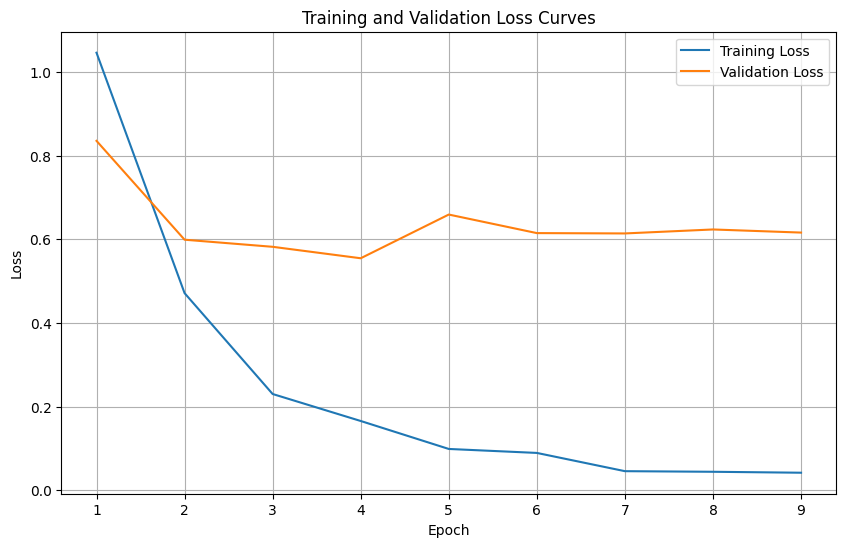

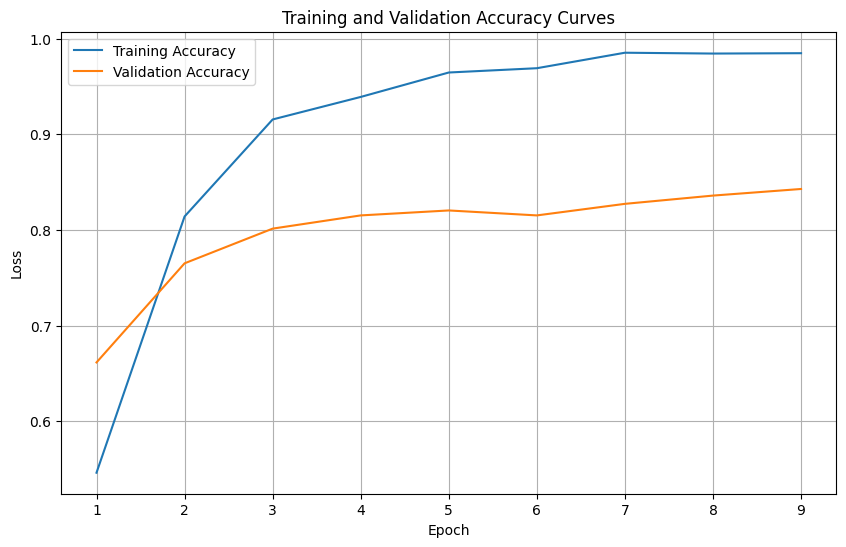


Classification Report:
               precision    recall  f1-score   support

       angry       0.86      0.85      0.86       140
       happy       0.88      0.86      0.87       148
     relaxed       0.80      0.76      0.78       146
         sad       0.79      0.87      0.83       138

    accuracy                           0.83       572
   macro avg       0.83      0.83      0.83       572
weighted avg       0.83      0.83      0.83       572


 F1 score: 0.8337873184251443; 
 Precision score: 0.8343076805967877; 
 Recall Score: 0.834486824525538


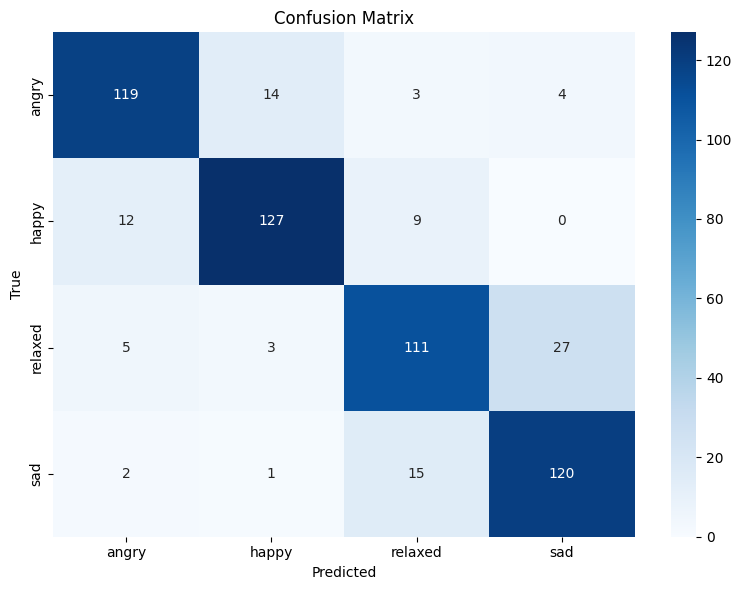

In [13]:
# load best model from training
print(BEST_MODEL_PATH)
final_model.load_state_dict(torch.load(BEST_MODEL_PATH))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plotting training and validation loss curves
if 'train_losses' in globals() and 'val_losses' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join(RESULTS_DIR, "loss_curves.png") #NOTE: specify by model name
    plt.savefig(loss_curve_path)
    plt.show()
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path)
else:
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.")

# plotting training and validation acc curves
if 'train_accs' in globals() and 'val_accs' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Training Accuracy")
    plt.plot(range(1, len(val_accs)+1), val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Accuracy Curves")
    plt.legend()
    plt.grid(True)
    acc_curve_path = os.path.join(RESULTS_DIR, "accuracy_curves.png")
    plt.savefig(acc_curve_path)
    plt.show()
    logging.info("Training and Validation Accuracy curves saved to %s", acc_curve_path)
else:
    logging.warning("train_accs and val_accs are not defined. Skipping accuracy curves plot.")

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)